# SNS injection painting

In [1]:
import sys
import importlib
import os
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import animation
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm import trange
import proplot as pplt 
import seaborn as sns

sys.path.append('..')
from tools import animation as myanim
from tools import beam_analysis as ba
from tools import plotting as myplt
from tools import utils

In [2]:
# Plot settings
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['savefig.dpi'] = 'figure'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['grid.alpha'] = 0.04
plt.rcParams['axes.grid'] = False
savefig_kws = dict(facecolor='white', dpi=300)

n_bins_hist2d = 50

In [3]:
utils.delete_files_not_folders('_output/figures/')

## Matched eigenvector 

In [4]:
# matched_eigvec = np.load('matched_eigenvector.npy')
# matched_env_params = np.load('matched_env_params.npy')

# eps = 40e-6 # intrinsic emittance [mm mrad]
# n_parts = 10000
# radii = np.sqrt(np.random.uniform(0, 4 * eps, size=(n_parts, 1)))
# phases = np.linspace(0, 2 * np.pi, n_parts).reshape(n_parts, 1) # eigenvector phase [rad]
# eigvecs = np.tile(matched_eigvec, (n_parts, 1))
# X = np.real(radii * eigvecs * np.exp(-1j * phases))

# myplt.corner(1e3 * X, 1e3 * matched_env_params);

In [5]:
# folder = '_output/data/'
folder = '_saved/yp=1.74_300turns_I=0.35e14_fringe=ON_sol=ON_sc=ON_imp=ON_rf=ON/data/'

## Injection region closed orbit

In [6]:
inj_region_coords_t0 = np.load(join(folder, 'inj_region_coords_t0.npy'))
inj_region_coords_t1 = np.load(join(folder, 'inj_region_coords_t1.npy'))
inj_region_positions_t0 = np.load(join(folder, 'inj_region_positions_t0.npy'))
inj_region_positions_t1 = np.load(join(folder, 'inj_region_positions_t1.npy'))
inj_region_positions_t0 -= 0.5 * inj_region_positions_t0[-1]
inj_region_positions_t1 -= 0.5 * inj_region_positions_t1[-1]
inj_region_coords_t0 *= 1000. # convert to mm-mrad
inj_region_coords_t1 *= 1000. # convert to mm-mrad

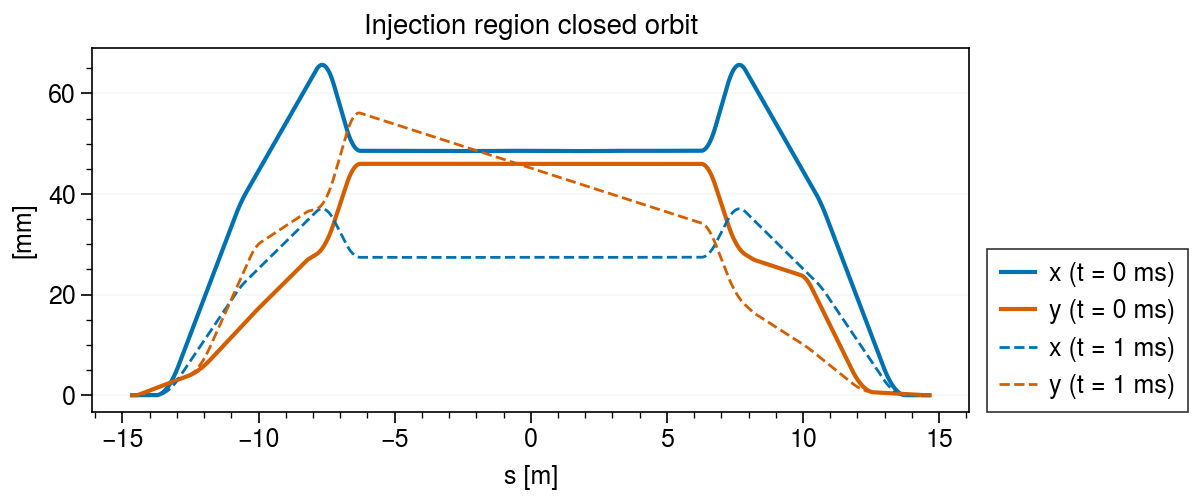

In [7]:
fig, ax = pplt.subplots(figsize=(6, 2.5))
ax.plot(inj_region_positions_t0, inj_region_coords_t0[:, 0])
ax.plot(inj_region_positions_t0, inj_region_coords_t0[:, 2])
ax.format(cycle='colorblind')
ax.plot(inj_region_positions_t1, inj_region_coords_t1[:, 0], ls='--', lw=1)
ax.plot(inj_region_positions_t1, inj_region_coords_t1[:, 2], ls='--', lw=1)
ax.format(title='Injection region closed orbit')
ax.legend(labels=('x (t = 0 ms)', 'y (t = 0 ms)', 'x (t = 1 ms)', 'y (t = 1 ms)'), 
          ncols=1, loc=(1.02, 0), handlelength=1.5);
ax.format(xlabel='s [m]', ylabel='[mm]') 
ax.grid(axis='y')
plt.savefig('_output/figures/inj_region_closed_orbit.png', **savefig_kws)

## Kicker strengths

In [8]:
kicker_angles_t0 = np.loadtxt(folder + 'kicker_angles_t0.dat')
kicker_angles_t1 = np.loadtxt(folder + 'kicker_angles_t1.dat')
kicker_names = ['ikickh_a10', 'ikickv_a10', 'ikickh_a11', 'ikickv_a11',
                'ikickv_a12', 'ikickh_a12', 'ikickv_a13', 'ikickh_a13']

In [9]:
def waveform(t, k0, k1):
    return k0 - (k0 - k1)*np.sqrt(t)

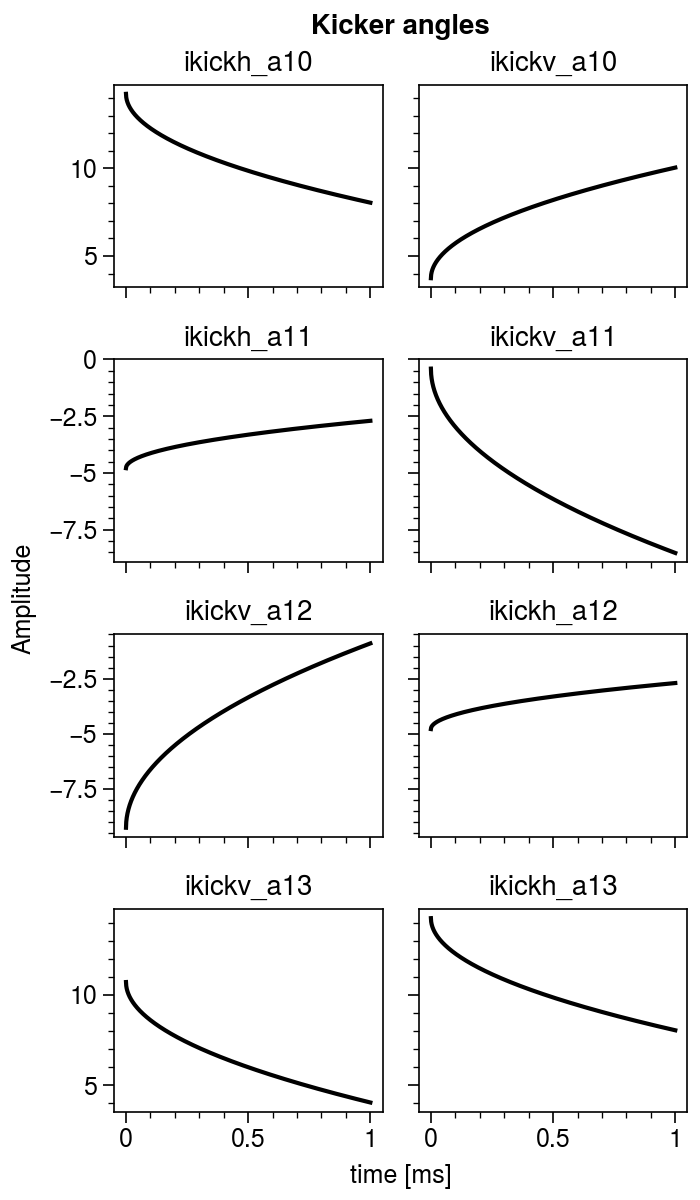

In [10]:
t = np.linspace(0, 1, 1000)

fig, axes = pplt.subplots(nrows=4, ncols=2, figsize=(3.5, 6))
for k0, k1, name, ax in zip(kicker_angles_t0, kicker_angles_t1, kicker_names, axes):
    ax.plot(t, 1000 * waveform(t, k0, k1), c='k')
    ax.format(title=name)
axes.format(ylabel='Amplitude', suptitle='Kicker angles', xlabel='time [ms]')
plt.savefig('_output/figures/kicker_angles.png', **savefig_kws)

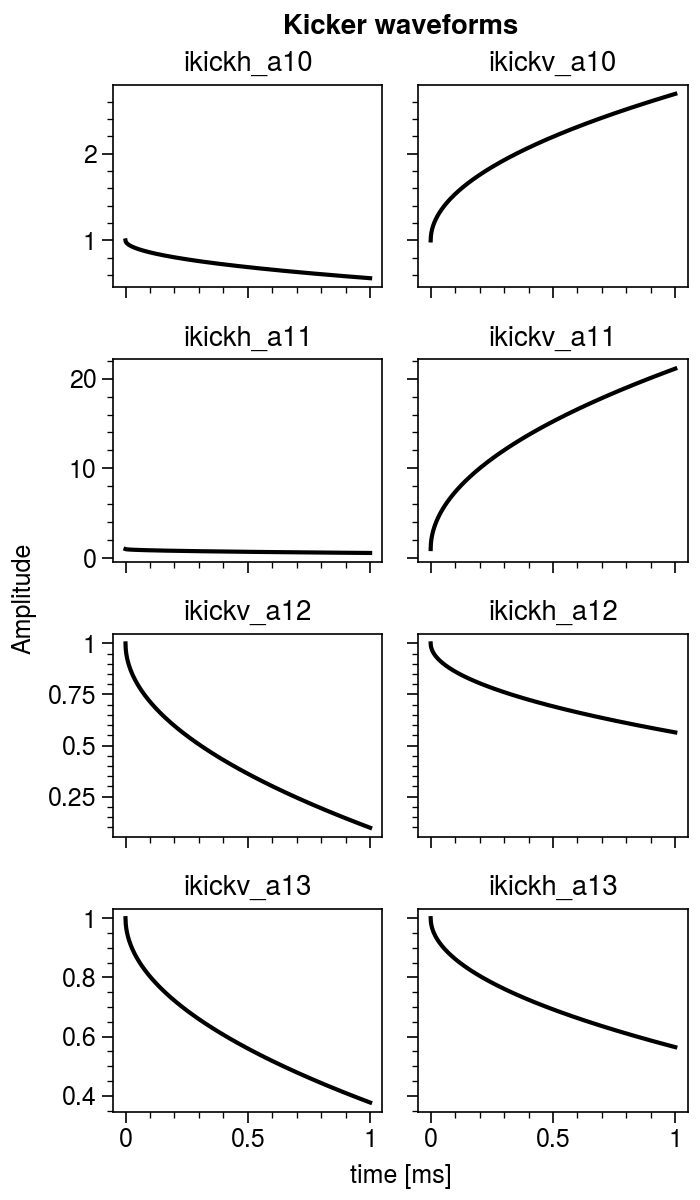

In [11]:
fig, axes = pplt.subplots(nrows=4, ncols=2, figsize=(3.5, 6))
for k0, k1, name, ax in zip(kicker_angles_t0, kicker_angles_t1, kicker_names, axes):
    ax.plot(t, waveform(t, 1.0, k1/k0), c='k')
    ax.format(title=name)
axes.format(ylabel='Amplitude', suptitle='Kicker waveforms', xlabel='time [ms]')
plt.savefig('_output/figures/kicker_waveforms.png', **savefig_kws)

## Beam statistics

In [12]:
coords = utils.load_stacked_arrays(join(folder, 'coords.npz'))
for i in range(len(coords)):
    coords[i][:, 5] *= 1000. # convert dE to [MeV]

In [13]:
moments_list = []
for X in tqdm(coords):
    Sigma = np.cov(X[:, :4].T)
    moments_list.append(ba.mat2vec(Sigma))
moments_list = np.array(moments_list)
    
stats = ba.StatsReader()
stats.read_moments(moments_list)

100%|██████████| 300/300 [00:05<00:00, 57.95it/s] 


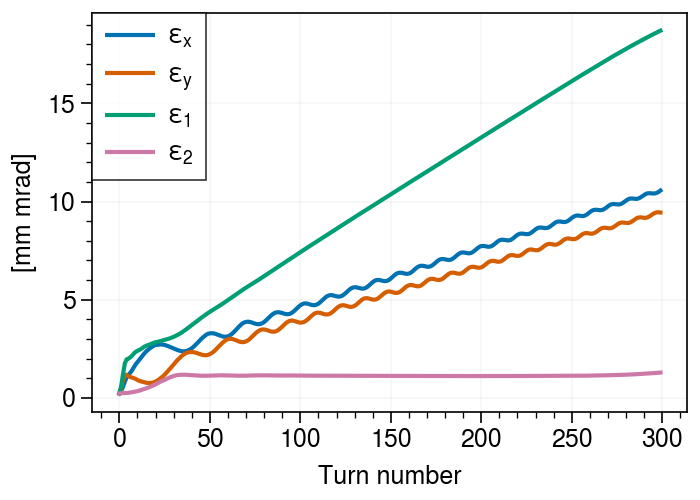

In [14]:
fig, ax = pplt.subplots(figsize=(3.5, 2.5))
plt_kws = dict(legend=False)
stats.twiss2D[['eps_x','eps_y']].plot(ax=ax, **plt_kws)
stats.twiss4D[['eps_1','eps_2']].plot(ax=ax, **plt_kws)
ax.legend(labels=[r'$\varepsilon_{}$'.format(v) for v in ['x', 'y', '1', '2']], 
          ncols=1, loc='upper left')
ax.format(ylabel='[mm mrad]', xlabel='Turn number', grid=True);
plt.savefig('_output/figures/emittances.png', **savefig_kws)

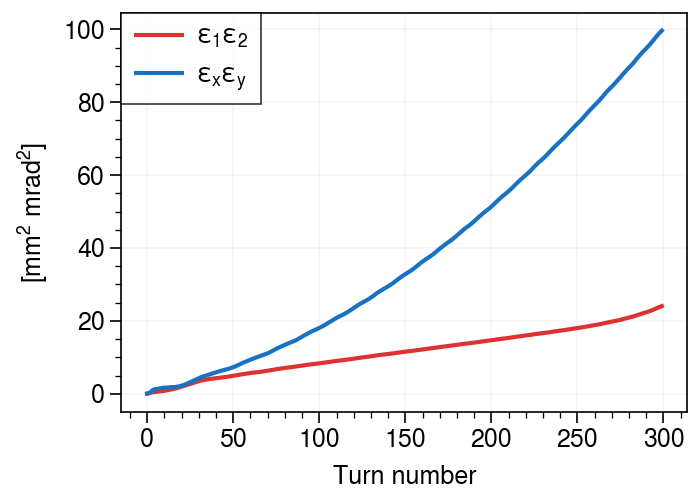

In [15]:
exey = (stats.twiss2D['eps_x'] * stats.twiss2D['eps_y']).values
e1e2 = (stats.twiss4D['eps_1'] * stats.twiss4D['eps_2']).values

fig, ax = pplt.subplots(figsize=(3.5, 2.5))
ax.plot(e1e2, color='red8')
ax.plot(exey, color='blue8')
ax.legend(labels=[r'$\varepsilon_1\varepsilon_2$', r'$\varepsilon_x\varepsilon_y$'],
          ncols=1, loc='upper left')
ax.format(xlabel='Turn number', ylabel=r'[mm$^2$ mrad$^2$]', 
          grid=True)
plt.savefig('_output/figures/emittances_4D.png', **savefig_kws)

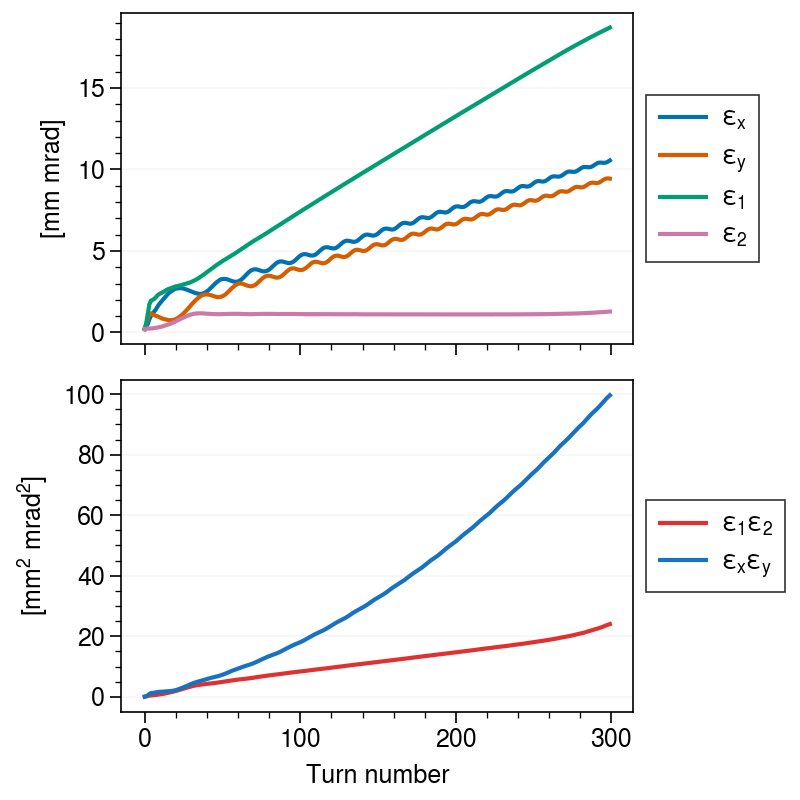

In [16]:
fig, axes = pplt.subplots(nrows=2, figsize=(4.0, 4.0), spany=False)
g1 = axes[0].plot(stats.twiss2D['eps_x'])
g2 = axes[0].plot(stats.twiss2D['eps_y'])
g3 = axes[0].plot(stats.twiss4D['eps_1'])
g4 = axes[0].plot(stats.twiss4D['eps_2'])
axes[0].legend(handles=[g1, g2, g3, g4],
               labels=[r'$\varepsilon_{}$'.format(v) for v in ['x', 'y', '1', '2']],
               ncols=1, loc='r')
g1 = axes[1].plot(e1e2, color='red8')
g2 = axes[1].plot(exey, color='blue8')
axes[1].legend(handles=[g1, g2],
               labels=[r'$\varepsilon_1\varepsilon_2$', r'$\varepsilon_x\varepsilon_y$'],
               ncols=1, loc='r')
axes[0].format(ylabel='[mm mrad]', xlabel='Turn number')
axes[1].format(ylabel=r'[mm$^2$ mrad$^2$]')
for ax in axes:
    ax.grid(axis='y')
plt.savefig('_output/figures/emittances_combined.png', **savefig_kws)

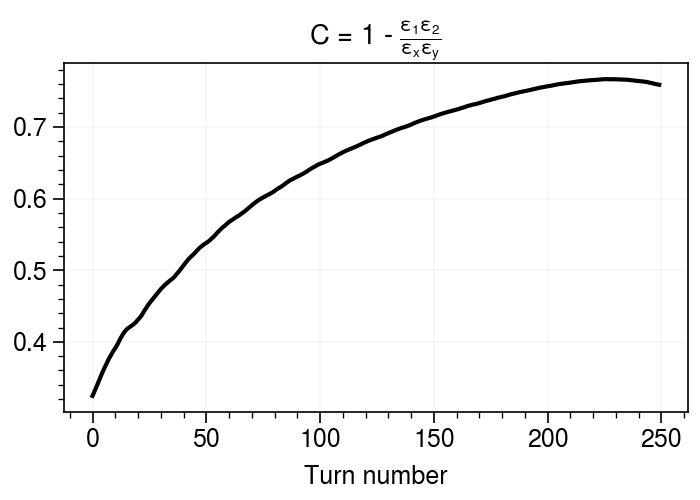

In [17]:
fig, ax = pplt.subplots(figsize=(3.5, 2.5))
C = 1.0 - (e1e2) / (exey)
ax.plot(C[50:], c='k')
ax.format(xlabel='Turn number', 
          title=r'C = 1 - $\frac{\varepsilon_1\varepsilon_2}{\varepsilon_x\varepsilon_y}$', 
          grid=True)
plt.savefig('_output/figures/coupling_factor.png', **savefig_kws)

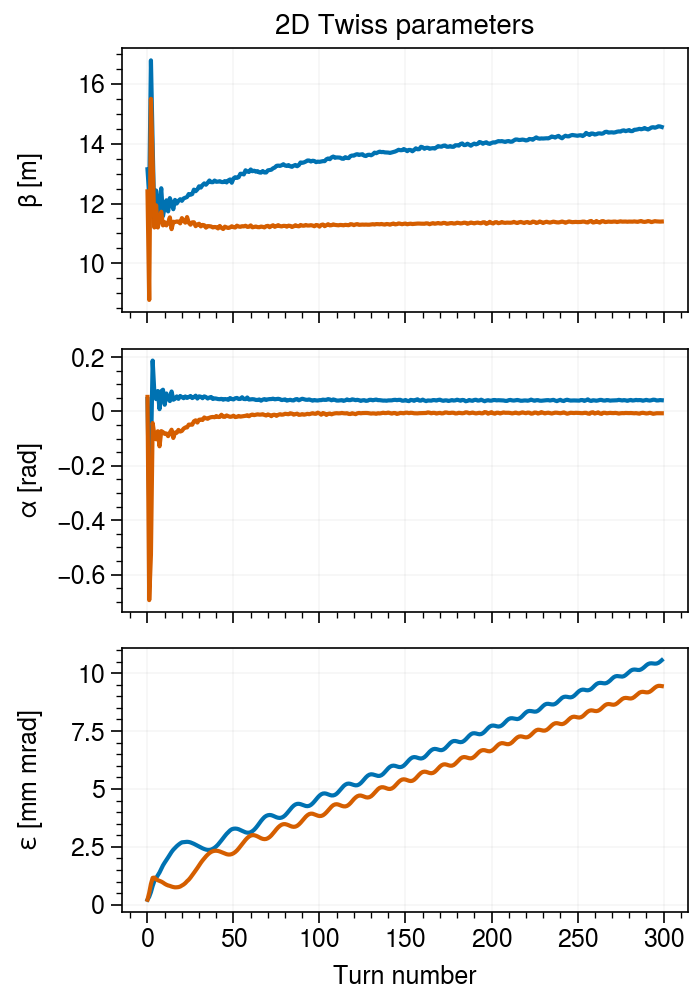

In [18]:
fig, axes = pplt.subplots(nrows=3, figsize=(3.5, 5.0), spany=False, aligny=True)
columns = (['beta_x','beta_y'], ['alpha_x','alpha_y'], ['eps_x','eps_y'])
ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm mrad]')
for ax, col in zip(axes, columns):
    stats.twiss2D[col].plot(ax=ax, **plt_kws)
axes.format(xlabel='Turn number', grid=True)
axes[0].format(title='2D Twiss parameters')
myplt.set_labels(axes, ylabels, 'ylabel')
plt.savefig('_output/figures/twiss2D.png', **savefig_kws)

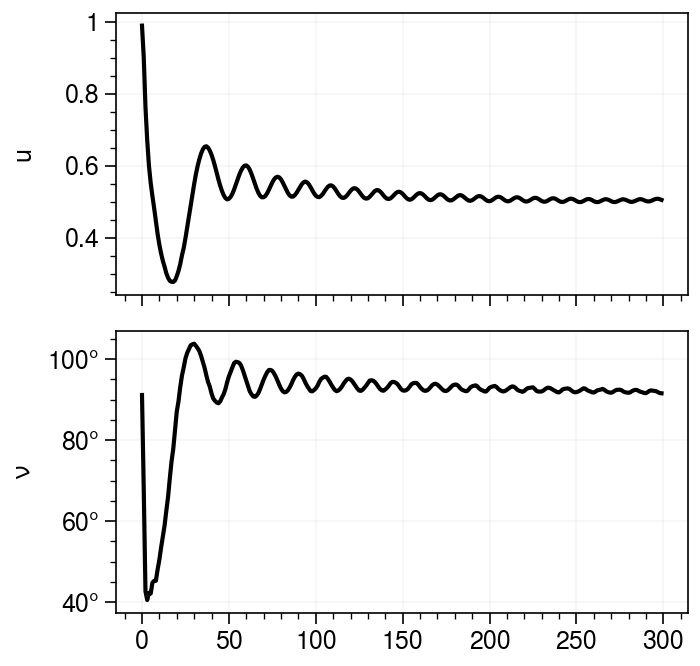

In [19]:
fig, axes = pplt.subplots(nrows=2, figsize=(3.5, 3.33), spany=False, aligny=True)
stats.twiss4D['u'].plot(color='k', ax=axes[0], **plt_kws)
stats.twiss4D['nu'].plot(color='k', ax=axes[1], **plt_kws)
axes.format(grid=True)
axes[0].format(ylabel='u')
axes[1].format(ylabel=r'$\nu$', yformatter='deg')
plt.savefig('_output/figures/u_and_nu.png', **savefig_kws)

In [20]:
display(stats.twiss2D)

,alpha_x,alpha_y,beta_x,beta_y,eps_x,eps_y,eps_x_frac,eps_y_frac
0,0.045592,0.053292,13.145067,12.406347,0.216940,0.220146,0.496333,0.503667
1,-0.348088,-0.694030,12.262401,8.774627,0.348104,0.518126,0.401861,0.598139
2,-0.159081,-0.527039,16.789443,15.501501,0.547264,0.896494,0.379055,0.620945
3,0.186921,-0.042794,13.962929,13.424273,0.813109,1.161403,0.411802,0.588198
4,0.067177,-0.087466,11.473822,11.198419,1.027823,1.173078,0.467001,0.532999
...,...,...,...,...,...,...,...,...
295,0.042512,-0.007803,14.534953,11.409910,10.408116,9.374051,0.526136,0.473864
296,0.040171,-0.006698,14.554078,11.401413,10.412906,9.422887,0.524955,0.475045
297,0.040481,-0.006808,14.584299,11.398065,10.441214,9.449619,0.524926,0.475074
298,0.041587,-0.006766,14.578473,11.394616,10.493413,9.449636,0.526169,0.473831


In [21]:
display(stats.twiss4D)

,alpha_x,alpha_y,beta_x,beta_y,u,nu,eps_1,eps_2,eps_4D
0,0.044411,0.052679,12.804506,12.263510,0.988487,91.126016,0.222710,0.214368,0.047742
1,-0.210770,-0.625496,7.424968,7.908145,0.901251,67.977716,0.574896,0.231770,0.133244
2,-0.074009,-0.401659,7.810894,11.813768,0.762105,42.630730,1.176340,0.237144,0.278962
3,0.087649,-0.028662,6.547364,8.991145,0.669768,40.492745,1.734039,0.237176,0.411273
4,0.035266,-0.052406,6.023419,6.709659,0.599161,42.295100,1.957867,0.242880,0.475527
...,...,...,...,...,...,...,...,...,...
295,0.023890,-0.003950,8.168160,5.774947,0.506134,92.129057,18.520876,1.256171,23.265383
296,0.022530,-0.003400,8.162480,5.786396,0.507516,92.046462,18.566691,1.263240,23.454190
297,0.022708,-0.003456,8.181102,5.786563,0.507679,91.822696,18.613359,1.271926,23.674819
298,0.023388,-0.003426,8.198652,5.770699,0.506441,91.595116,18.658912,1.278461,23.854692


## TBT coordinates 

In [22]:
foil_pos = (48.6, 46.0)
coords_foil_frame = []
for X in coords:
    Y = np.copy(X)
    Y[:, 0] -= foil_pos[0]
    Y[:, 2] -= foil_pos[1]
    coords_foil_frame.append(Y)

In [24]:
turn = -1
plot_kws = dict(pad=-0.2, bins=50, hist_height_frac=0.6)

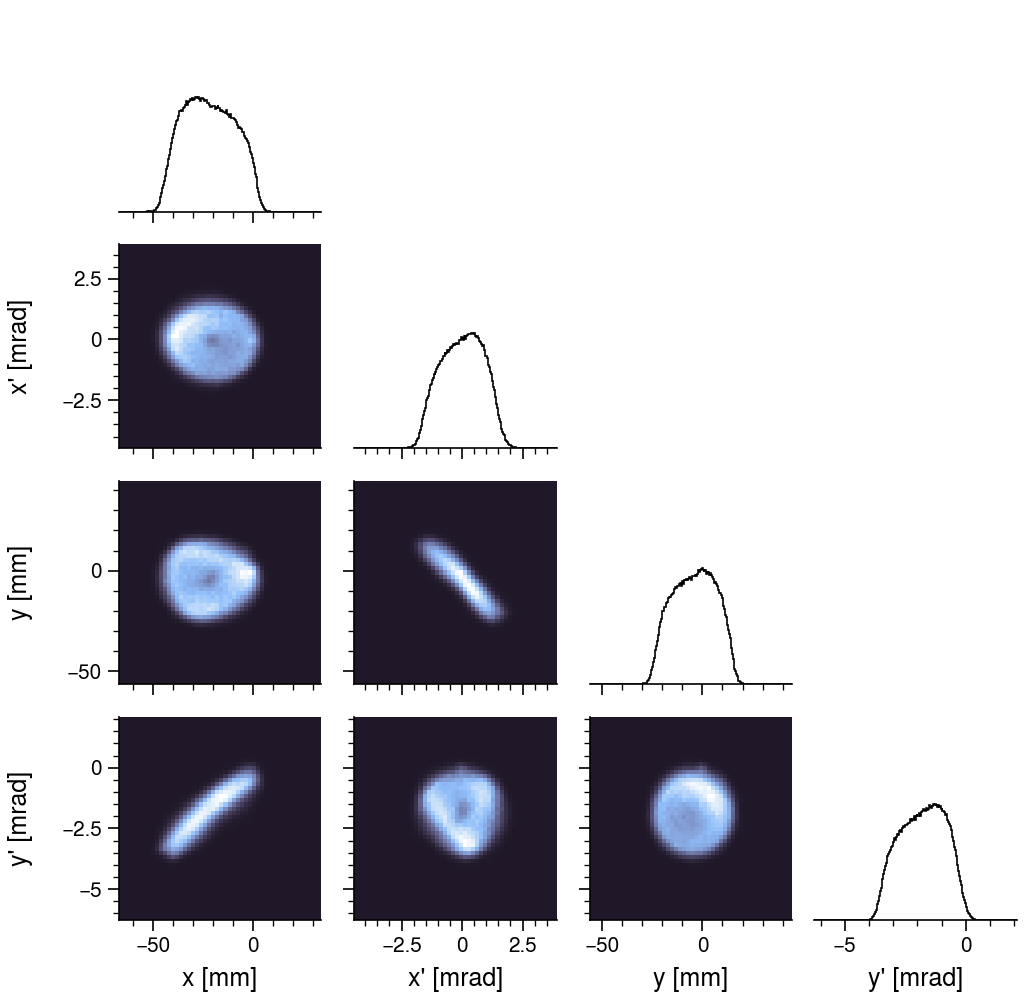

In [25]:
axes = myplt.corner(coords_foil_frame[turn][:, :4], **plot_kws)
plt.savefig('_output/figures/corner4D_turn{}.png'.format(turn), **savefig_kws)

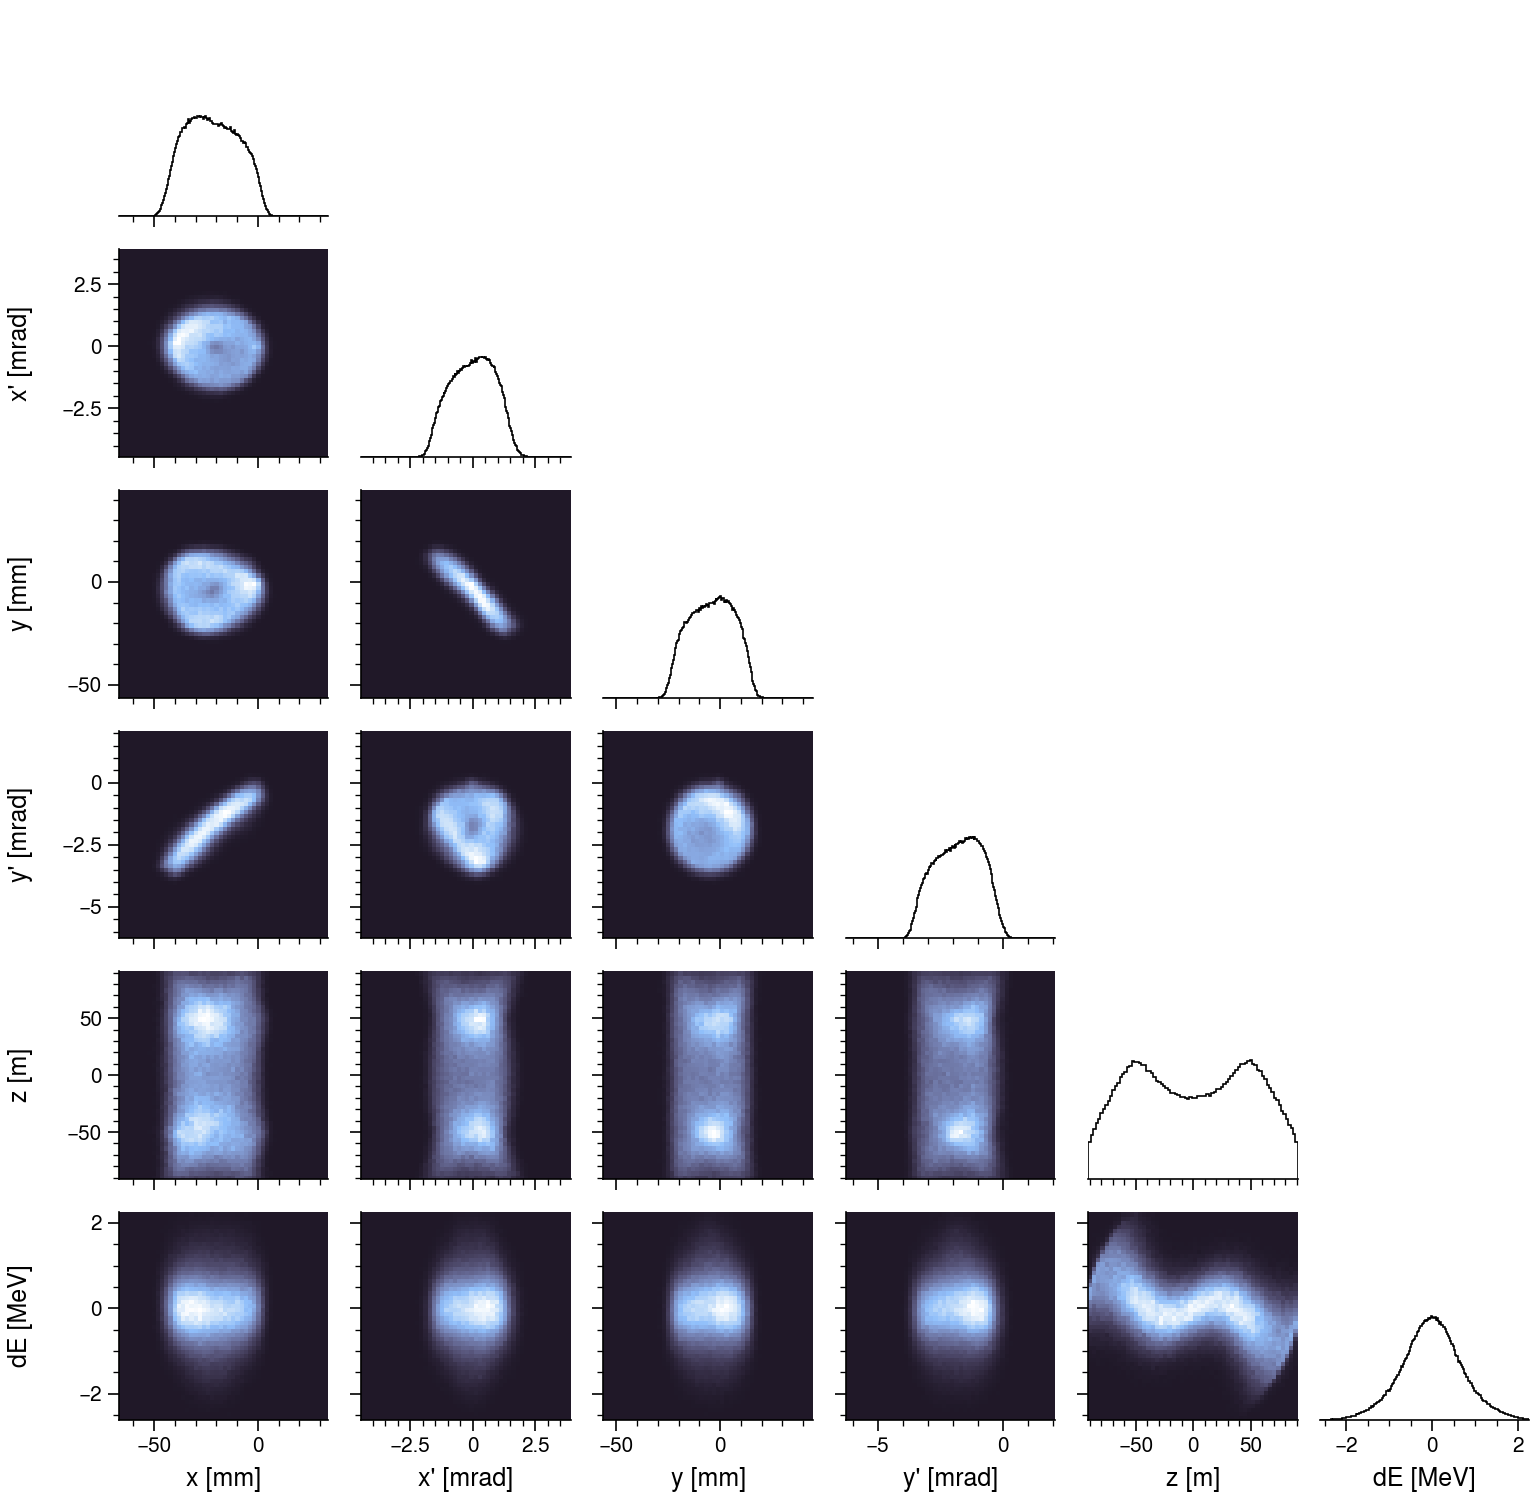

In [26]:
axes = myplt.corner(coords_foil_frame[-1], **plot_kws)
plt.savefig('_output/figures/corner6D_turn{}.png'.format(turn), **savefig_kws)

In [29]:
anim_kws = dict(skip=19, keep_last=True, text_fmt='Turn = {}', 
                bins=50, pad=-0.3, hist_height_frac=0.6)

In [ ]:
anim = myanim.corner(coords_foil_frame, dims=4, **anim_kws)
anim.save('_output/figures/corner4D.mp4', dpi=350, fps=5)

100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


In [ ]:
anim = myanim.corner(coords_foil_frame, dims=6, **anim_kws)
anim.save('_output/figures/corner6D.mp4', dpi=350, fps=5)

In [ ]:
i = 0
X_onepart = np.array([X[i, :4] for X in coords_foil_frame])

axes = myplt.corner(X_onepart)
plt.savefig('_output/figures/corner_part{}.png'.format(i), **savefig_kws)

In [ ]:
# anim = myanim.corner_onepart(
#     X_onepart[:50], show_history=True, skip=0, pad=0.35, text_fmt='Turn = {}', 
#     zero_center=False, history_kws=dict(ms=5, color='lightgrey'),
# )
# anim.save('_output/figures/corner_part{}.mp4'.format(i), dpi=350, fps=5)